# Inference and Validation

Now that you have a trained network, you can use it for making predictions. This is typically called **inference**, a term borrowed from statistics. However, neural networks have a tendency to perform *too well* on the training data and aren't able to generalize to data that hasn't been seen before. This is called **overfitting** and it impairs inference performance. To test for overfitting while training, we measure the performance on data not in the training set called the **validation** set. We avoid overfitting through regularization such as dropout while monitoring the validation performance during training. In this notebook, I'll show you how to do this in PyTorch. 

As usual, let's start by loading the dataset through torchvision. You'll learn more about torchvision and loading data in a later part. This time we'll be taking advantage of the test set which you can get by setting `train=False` here:

```python
testset = datasets.FashionMNIST('~/.pytorch/F_MNIST_data/', download=True, train=False, transform=transform)
```

The test set contains images just like the training set. Typically you'll see 10-20% of the original dataset held out for testing and validation with the rest being used for training.

In [9]:
import torch
from torch.utils.data import Dataset, DataLoader 
import os
class myDataset(Dataset):
    def __init__(self, loadPath): #r'home/tongqing.li/lesson/pytorch/MNIST_data/MNIST/processed/training.pt'
        super(myDataset, self).__init__()
        self.data = torch.load(loadPath)
    
    def __getitem__(self, index):
        return (self.data[0][index].unsqueeze(0).float()/255, self.data[1][index].long())
    
    def __len__(self):
        return len(self.data[0])

In [10]:
a = myDataset(r'home/tongqing.li/lesson/pytorch/MNIST_data/MNIST/processed/training.pt')
b = myDataset(r'home/tongqing.li/lesson/pytorch/MNIST_data/MNIST/processed/test.pt')

In [11]:
import torch
from torchvision import datasets, transforms

# Define a transform to normalize the data
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.5,), (0.5,))])
# Download and load the training data
#trainset = datasets.FashionMNIST('~/.pytorch/F_MNIST_data1/', download=True, train=True, transform=transform)
#trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)
trainset = datasets.MNIST(r'home/tongqing.li/lesson/pytorch/MNIST_data/', download=True, train=True, transform=transform)
trainloader = torch.utils.data.DataLoader(a, batch_size=64, shuffle=True)

# Download and load the test data
#testset = datasets.FashionMNIST('~/.pytorch/F_MNIST_data1/', download=True, train=False, transform=transform)
#testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=True)
testset = datasets.MNIST(r'home/tongqing.li/lesson/pytorch/MNIST_data/', download=True, train=False, transform=transform)
testloader = torch.utils.data.DataLoader(b, batch_size=64, shuffle=True)

In [12]:
%matplotlib inline
import helper

images, labels = next(iter(trainloader))

img = images[0].unsqueeze(0)
img = img.to(device)
model.eval()
# Turn off gradients to speed up this part
with torch.no_grad():
    logps = model(img)

# Output of the network are log-probabilities, need to take exponential for probabilities
print(logps.shape)
ps = torch.softmax(logps, dim = 1).cpu()
print(ps)
print("label", labels[0])
helper.view_classify(img.view(1, 28, 28).cpu(), ps)

NameError: name 'model' is not defined

Here I'll create a model like normal, using the same one from my solution for part 4.

In [15]:
from torch import nn, optim
import torch.nn.functional as F

class Classifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc0 = nn.Linear(784, 200)
        self.fc1 = nn.Linear(200, 80)
        self.fc2 = nn.Linear(80, 10)
        
    def forward(self, x):
        # make sure input tensor is flattened
        x = x.view(x.shape[0], -1)
        
        x = F.relu(self.fc0(x))
        x = F.relu(self.fc1(x))
        x = F.log_softmax(self.fc2(x), dim=1)
        
        return x

The goal of validation is to measure the model's performance on data that isn't part of the training set. Performance here is up to the developer to define though. Typically this is just accuracy, the percentage of classes the network predicted correctly. Other options are [precision and recall](https://en.wikipedia.org/wiki/Precision_and_recall#Definition_(classification_context)) and top-5 error rate. We'll focus on accuracy here. First I'll do a forward pass with one batch from the test set.

In [64]:
model = Classifier()

images, labels = next(iter(testloader))
# Get the class probabilities
ps = torch.exp(model(images))
# Make sure the shape is appropriate, we should get 10 class probabilities for 64 examples
print(ps.shape)

torch.Size([64, 10])


With the probabilities, we can get the most likely class using the `ps.topk` method. This returns the $k$ highest values. Since we just want the most likely class, we can use `ps.topk(1)`. This returns a tuple of the top-$k$ values and the top-$k$ indices. If the highest value is the fifth element, we'll get back 4 as the index.

In [65]:
top_p, top_class = ps.topk(1, dim=1)
# Look at the most likely classes for the first 10 examples
print(top_p[:10,:], top_class[:10,:])

tensor([[0.1105],
        [0.1115],
        [0.1104],
        [0.1101],
        [0.1108],
        [0.1104],
        [0.1108],
        [0.1107],
        [0.1106],
        [0.1106]], grad_fn=<SliceBackward>) tensor([[6],
        [6],
        [6],
        [6],
        [6],
        [6],
        [6],
        [6],
        [6],
        [6]])


Now we can check if the predicted classes match the labels. This is simple to do by equating `top_class` and `labels`, but we have to be careful of the shapes. Here `top_class` is a 2D tensor with shape `(64, 1)` while `labels` is 1D with shape `(64)`. To get the equality to work out the way we want, `top_class` and `labels` must have the same shape.

If we do

```python
equals = top_class == labels
```

`equals` will have shape `(64, 64)`, try it yourself. What it's doing is comparing the one element in each row of `top_class` with each element in `labels` which returns 64 True/False boolean values for each row.

In [66]:
equals = top_class == labels.view(*top_class.shape)

Now we need to calculate the percentage of correct predictions. `equals` has binary values, either 0 or 1. This means that if we just sum up all the values and divide by the number of values, we get the percentage of correct predictions. This is the same operation as taking the mean, so we can get the accuracy with a call to `torch.mean`. If only it was that simple. If you try `torch.mean(equals)`, you'll get an error

```
RuntimeError: mean is not implemented for type torch.ByteTensor
```

This happens because `equals` has type `torch.ByteTensor` but `torch.mean` isn't implement for tensors with that type. So we'll need to convert `equals` to a float tensor. Note that when we take `torch.mean` it returns a scalar tensor, to get the actual value as a float we'll need to do `accuracy.item()`.

In [67]:
accuracy = torch.mean(equals.type(torch.FloatTensor))
print(f'Accuracy: {accuracy.item()*100}%')

Accuracy: 15.625%


The network is untrained so it's making random guesses and we should see an accuracy around 10%. Now let's train our network and include our validation pass so we can measure how well the network is performing on the test set. Since we're not updating our parameters in the validation pass, we can speed up the  by turning off gradients using `torch.no_grad()`:

```python
# turn off gradients
with torch.no_grad():
    # validation pass here
    for images, labels in testloader:
        ...
```

>**Exercise:** Implement the validation loop below. You can largely copy and paste the code from above, but I suggest typing it in because writing it out yourself is essential for building the skill. In general you'll always learn more by typing it rather than copy-pasting.

In [7]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [347]:
#model = Classifier()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001)

#model.to(device)


epochs = 500
steps = 0

train_losses, test_losses = [], []
for e in range(301,epochs):
    running_loss = 0
    for images, labels in trainloader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        
        log_ps = model(images)
        loss = criterion(log_ps, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        
    else:
        test_loss = 0
        accuracy = 0
        
        # Turn off gradients for validation, saves memory and computations
        with torch.no_grad():
            for images, labels in testloader:
                images, labels = images.to(device), labels.to(device)
                log_ps = model(images)
                test_loss += criterion(log_ps, labels)
                
                ps = torch.exp(log_ps)
                top_p, top_class = ps.topk(1, dim=1)
                equals = top_class == labels.view(*top_class.shape)
                accuracy += torch.mean(equals.type(torch.FloatTensor))
                
        train_losses.append(running_loss/len(trainloader))#吧中间结果放到数组中来。
        test_losses.append(test_loss/len(testloader))

        print("Epoch: {}/{}.. ".format(e+1, epochs),
              "Training Loss: {:.3f}.. ".format(running_loss/len(trainloader)),
              "Test Loss: {:.3f}.. ".format(test_loss/len(testloader)),
              "Test Accuracy: {:.3f}".format(accuracy/len(testloader)))

RuntimeError: Expected 4-dimensional input for 4-dimensional weight 6 1 5 5, but got 3-dimensional input of size [64, 28, 28] instead

In [77]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import matplotlib.pyplot as plt

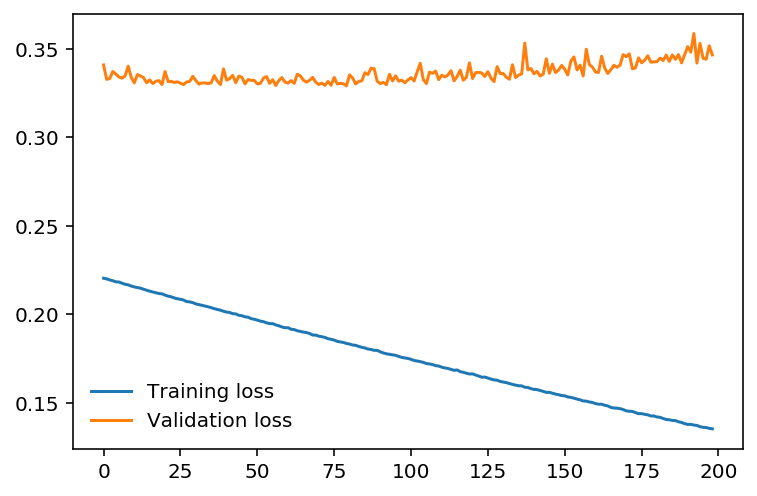

In [78]:
plt.plot(train_losses, label='Training loss')
plt.plot(test_losses, label='Validation loss')
plt.legend(frameon=False)

## Overfitting

If we look at the training and validation losses as we train the network, we can see a phenomenon known as overfitting.

<img src='assets/overfitting.png' width=450px>

The network learns the training set better and better, resulting in lower training losses. However, it starts having problems generalizing to data outside the training set leading to the validation loss increasing. The ultimate goal of any deep learning model is to make predictions on new data, so we should strive to get the lowest validation loss possible. One option is to use the version of the model with the lowest validation loss, here the one around 8-10 training epochs. This strategy is called *early-stopping*. In practice, you'd save the model frequently as you're training then later choose the model with the lowest validation loss.

The most common method to reduce overfitting (outside of early-stopping) is *dropout*, where we randomly drop input units. This forces the network to share information between weights, increasing it's ability to generalize to new data. Adding dropout in PyTorch is straightforward using the [`nn.Dropout`](https://pytorch.org/docs/stable/nn.html#torch.nn.Dropout) module.

```python
class Classifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(784, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 64)
        self.fc4 = nn.Linear(64, 10)
        
        # Dropout module with 0.2 drop probability
        self.dropout = nn.Dropout(p=0.2)
        
    def forward(self, x):
        # make sure input tensor is flattened
        x = x.view(x.shape[0], -1)
        
        # Now with dropout
        x = self.dropout(F.relu(self.fc1(x)))
        x = self.dropout(F.relu(self.fc2(x)))
        x = self.dropout(F.relu(self.fc3(x)))
        
        # output so no dropout here
        x = F.log_softmax(self.fc4(x), dim=1)
        
        return x
```

During training we want to use dropout to prevent overfitting, but during inference we want to use the entire network. So, we need to turn off dropout during validation, testing, and whenever we're using the network to make predictions. To do this, you use `model.eval()`. This sets the model to evaluation mode where the dropout probability is 0. You can turn dropout back on by setting the model to train mode with `model.train()`. In general, the pattern for the validation loop will look like this, where you turn off gradients, set the model to evaluation mode, calculate the validation loss and metric, then set the model back to train mode.

```python
# turn off gradients
with torch.no_grad():
    
    # set model to evaluation mode
    model.eval()
    
    # validation pass here
    for images, labels in testloader:
        ...

# set model back to train mode
model.train()
```

> **Exercise:** Add dropout to your model and train it on Fashion-MNIST again. See if you can get a lower validation loss.

In [12]:
class Classifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(784, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 64)
        self.fc4 = nn.Linear(64, 10)

        # Dropout module with 0.2 drop probability
        self.dropout = nn.Dropout(p=0.2)

    def forward(self, x):
        # make sure input tensor is flattened
        x = x.view(x.shape[0], -1)

        # Now with dropout
        x = self.dropout(F.relu(self.fc1(x)))
        x = self.dropout(F.relu(self.fc2(x)))
        x = self.dropout(F.relu(self.fc3(x)))

        # output so no dropout here
        x = F.log_softmax(self.fc4(x), dim=1)

        return x

In [13]:
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):

    def __init__(self):
        super(Net, self).__init__()
        # 1 input image channel, 6 output channels, 3x3 square convolution
        # kernel
        self.pool1 = nn.MaxPool2d(2, 2)
        self.conv1 = nn.Conv2d(1, 6, 5, padding = 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.conv3 = nn.Conv2d(16, 120, 5)
        # an affine operation: y = Wx + b 
        self.fc1 = nn.Linear(120, 84)
        self.fc2 = nn.Linear(84, 10)

    def forward(self, x):
        # Max pooling over a (2, 2) window
        x = self.pool1(torch.sigmoid(self.conv1(x)))
        #print(x[0])
        # If the size is a square you can only specify a single number
        x = self.pool1(torch.sigmoid(self.conv2(x)))
        x = F.relu(self.conv3(x))
        x = x.view(-1, self.num_flat_features(x))
        x = torch.sigmoid(self.fc1(x))
        x = self.fc2(x)
        return x
    def num_flat_features(self, x):
        size = x.size()[1:]  # all dimensions except the batch dimension
        num_features = 1
        for s in size:
            num_features *= s
        return num_features

In [18]:
model = Net()
model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.1)

epochs = 300
steps = 0

train_losses, test_losses = [], []
for e in range(epochs):
    running_loss = 0
    for images, labels in trainloader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        
        log_ps = model(images)
        loss = criterion(log_ps, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        
    else:
        test_loss = 0
        accuracy = 0
        
        # Turn off gradients for validation, saves memory and computations
        with torch.no_grad():
            model.eval()#这里就是关闭dropout了。
            for images, labels in testloader:
                images, labels = images.to(device), labels.to(device)
                log_ps = model(images)
                test_loss += criterion(log_ps, labels)
                
                ps = torch.exp(log_ps)
                top_p, top_class = ps.topk(1, dim=1)
                equals = top_class == labels.view(*top_class.shape)
                accuracy += torch.mean(equals.type(torch.FloatTensor))
        
        model.train()
        
        train_losses.append(running_loss/len(trainloader))
        test_losses.append(test_loss/len(testloader))

        print("Epoch: {}/{}.. ".format(e+1, epochs),
              "Training Loss: {:.4f}.. ".format(train_losses[-1]),
              "Test Loss: {:.4f}.. ".format(test_losses[-1]),
              "Test Accuracy: {:.4f}".format(accuracy/len(testloader)))

Epoch: 1/300..  Training Loss: 2.3091..  Test Loss: 2.3124..  Test Accuracy: 0.1136
Epoch: 2/300..  Training Loss: 2.3055..  Test Loss: 2.3048..  Test Accuracy: 0.1010
Epoch: 3/300..  Training Loss: 2.3022..  Test Loss: 2.3003..  Test Accuracy: 0.1029
Epoch: 4/300..  Training Loss: 2.2978..  Test Loss: 2.2923..  Test Accuracy: 0.0981
Epoch: 5/300..  Training Loss: 1.8488..  Test Loss: 0.9081..  Test Accuracy: 0.7012
Epoch: 6/300..  Training Loss: 0.5430..  Test Loss: 0.3557..  Test Accuracy: 0.8971
Epoch: 7/300..  Training Loss: 0.2484..  Test Loss: 0.1791..  Test Accuracy: 0.9486
Epoch: 8/300..  Training Loss: 0.1688..  Test Loss: 0.1329..  Test Accuracy: 0.9612
Epoch: 9/300..  Training Loss: 0.1315..  Test Loss: 0.1396..  Test Accuracy: 0.9578
Epoch: 10/300..  Training Loss: 0.1094..  Test Loss: 0.0901..  Test Accuracy: 0.9731
Epoch: 11/300..  Training Loss: 0.0947..  Test Loss: 0.1078..  Test Accuracy: 0.9660
Epoch: 12/300..  Training Loss: 0.0842..  Test Loss: 0.0664..  Test Accura

Epoch: 98/300..  Training Loss: 0.0030..  Test Loss: 0.0378..  Test Accuracy: 0.9890
Epoch: 99/300..  Training Loss: 0.0029..  Test Loss: 0.0383..  Test Accuracy: 0.9894
Epoch: 100/300..  Training Loss: 0.0028..  Test Loss: 0.0386..  Test Accuracy: 0.9892
Epoch: 101/300..  Training Loss: 0.0027..  Test Loss: 0.0395..  Test Accuracy: 0.9893
Epoch: 102/300..  Training Loss: 0.0026..  Test Loss: 0.0404..  Test Accuracy: 0.9890
Epoch: 103/300..  Training Loss: 0.0026..  Test Loss: 0.0389..  Test Accuracy: 0.9883
Epoch: 104/300..  Training Loss: 0.0025..  Test Loss: 0.0398..  Test Accuracy: 0.9885
Epoch: 105/300..  Training Loss: 0.0025..  Test Loss: 0.0397..  Test Accuracy: 0.9884
Epoch: 106/300..  Training Loss: 0.0024..  Test Loss: 0.0399..  Test Accuracy: 0.9890
Epoch: 107/300..  Training Loss: 0.0023..  Test Loss: 0.0390..  Test Accuracy: 0.9883
Epoch: 108/300..  Training Loss: 0.0023..  Test Loss: 0.0387..  Test Accuracy: 0.9888
Epoch: 109/300..  Training Loss: 0.0023..  Test Loss: 0.

Epoch: 194/300..  Training Loss: 0.0006..  Test Loss: 0.0451..  Test Accuracy: 0.9891
Epoch: 195/300..  Training Loss: 0.0006..  Test Loss: 0.0449..  Test Accuracy: 0.9888
Epoch: 196/300..  Training Loss: 0.0006..  Test Loss: 0.0455..  Test Accuracy: 0.9889
Epoch: 197/300..  Training Loss: 0.0006..  Test Loss: 0.0454..  Test Accuracy: 0.9889
Epoch: 198/300..  Training Loss: 0.0006..  Test Loss: 0.0455..  Test Accuracy: 0.9887
Epoch: 199/300..  Training Loss: 0.0006..  Test Loss: 0.0456..  Test Accuracy: 0.9889
Epoch: 200/300..  Training Loss: 0.0006..  Test Loss: 0.0452..  Test Accuracy: 0.9886
Epoch: 201/300..  Training Loss: 0.0006..  Test Loss: 0.0456..  Test Accuracy: 0.9887
Epoch: 202/300..  Training Loss: 0.0006..  Test Loss: 0.0452..  Test Accuracy: 0.9884
Epoch: 203/300..  Training Loss: 0.0006..  Test Loss: 0.0456..  Test Accuracy: 0.9890
Epoch: 204/300..  Training Loss: 0.0006..  Test Loss: 0.0458..  Test Accuracy: 0.9886
Epoch: 205/300..  Training Loss: 0.0006..  Test Loss: 

Epoch: 290/300..  Training Loss: 0.0003..  Test Loss: 0.0479..  Test Accuracy: 0.9887
Epoch: 291/300..  Training Loss: 0.0003..  Test Loss: 0.0483..  Test Accuracy: 0.9892
Epoch: 292/300..  Training Loss: 0.0003..  Test Loss: 0.0481..  Test Accuracy: 0.9888
Epoch: 293/300..  Training Loss: 0.0003..  Test Loss: 0.0481..  Test Accuracy: 0.9889
Epoch: 294/300..  Training Loss: 0.0003..  Test Loss: 0.0484..  Test Accuracy: 0.9889
Epoch: 295/300..  Training Loss: 0.0003..  Test Loss: 0.0483..  Test Accuracy: 0.9886
Epoch: 296/300..  Training Loss: 0.0003..  Test Loss: 0.0484..  Test Accuracy: 0.9889
Epoch: 297/300..  Training Loss: 0.0003..  Test Loss: 0.0479..  Test Accuracy: 0.9885
Epoch: 298/300..  Training Loss: 0.0003..  Test Loss: 0.0516..  Test Accuracy: 0.9881
Epoch: 299/300..  Training Loss: 0.0003..  Test Loss: 0.0482..  Test Accuracy: 0.9889
Epoch: 300/300..  Training Loss: 0.0003..  Test Loss: 0.0483..  Test Accuracy: 0.9885


In [407]:
for images, labels in trainloader:
    print(images[0])
        

tensor([[[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.3294, 0.9922, 0.5765,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.8078, 0.9882, 0.5765,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.2039, 0.9490, 0.8667, 0.2902,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,

tensor([[[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,

tensor([[[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,

tensor([[[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,

tensor([[[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,

tensor([[[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [186]:
for x in trainloader:
    print(x)

TypeError: function takes exactly 1 argument (3 given)

In [210]:
for model_layer in model.modules():
    print(model_layer)

Net(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (conv3): Conv2d(16, 120, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=120, out_features=84, bias=True)
  (fc2): Linear(in_features=84, out_features=10, bias=True)
)
Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
Conv2d(16, 120, kernel_size=(5, 5), stride=(1, 1))
Linear(in_features=120, out_features=84, bias=True)
Linear(in_features=84, out_features=10, bias=True)


In [214]:
for name, m in model.named_children( ):
    print('name',name,'model',m)

name conv1 model Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
name conv2 model Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
name conv3 model Conv2d(16, 120, kernel_size=(5, 5), stride=(1, 1))
name fc1 model Linear(in_features=120, out_features=84, bias=True)
name fc2 model Linear(in_features=84, out_features=10, bias=True)


In [215]:
for index,layer in enumerate(model):
    print(layder)

TypeError: 'Net' object is not iterable

# FeatureVisualization 

In [241]:
class FeatureVisualization():
    def __init__(self,model,transform,selected_layer,select_filter,img,img_path=None,is_transform=True):
        self.img_path=img_path
        self.selected_layer=selected_layer
        self.pretrained_model = model
        self.transform=transform
        self.is_transform=is_transform
        self.img=img
    def imread(path):
        # open path as file to avoid ResourceWarning (https://github.com/python-pillow/Pillow/issues/835)
        with open(path, 'rb') as f:
            img = Image.open(f)
        return img.convert('RGB')#将图片转换为RGB格式。
        #print( self.pretrained_model)
    def process_image(self,img):
        if(self.img_path is not None):
            img=imread(self.img_path)
        if(not self.is_transform):
            img=self.transform(self.img)
        device = 'cuda' if torch.cuda.is_available() else 'cpu'
        if(torch.cuda.is_available()):
            img=img.to(device)
        return img

    def get_feature(self):
        # input = Variable(torch.randn(1, 3, 224, 224))
        input=self.process_image(self.img)
        #print("input shape",input.shape)
        x=input
        for index,(name,layer) in enumerate(model.named_children()):
            #print(index)
            #print(layer)
            x=layer(x)
            if (index == self.selected_layer):
                return x

    def get_single_feature(self):
        features=self.get_feature()
        print("features.shape",features.shape)
        feature=features[:,0,:,:]
        print(feature.shape)
        feature=feature.view(feature.shape[1],feature.shape[2])
        print(feature.shape)
        return features

    def save_feature_to_img(self):
        #to numpy
        features=self.get_single_feature()
        for i in range(features.shape[1]):
            feature = features[:, i, :, :]
            feature = feature.view(feature.shape[1], feature.shape[2])
            feature = feature.data.numpy()
            # use sigmod to [0,1]
            feature = 1.0 / (1 + np.exp(-1 * feature))
            # to [0,255]
            feature = np.round(feature * 255)
            print(feature[0])
            mkdir('./feature/' + str(self.selected_layer))
            cv2.imwrite('./feature/'+ str( self.selected_layer)+'/' +str(i)+'.jpg', feature)

In [261]:
for i in model.named_children():
    print(i[1])

Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
Conv2d(16, 120, kernel_size=(5, 5), stride=(1, 1))
Linear(in_features=120, out_features=84, bias=True)
Linear(in_features=84, out_features=10, bias=True)


In [269]:
print(img.shape)

torch.Size([1, 1, 28, 28])


In [307]:
FV=FeatureVisualization(model=model,transform=transform,selected_layer=2,select_filter=1,img=img)

In [308]:
feature=FV.get_single_feature()
feature = feature.cpu()

features.shape torch.Size([1, 16, 10, 10])
torch.Size([1, 10, 10])
torch.Size([10, 10])


In [272]:
feature

tensor([[[[-1.3042e+00, -9.9482e-01, -4.4348e-01,  ..., -4.4348e-01,
            1.1408e-02,  8.1392e-01],
          [-1.8819e+00, -1.3277e+00, -5.7763e-01,  ..., -5.7763e-01,
            2.0648e-01,  1.2629e+00],
          [-2.2266e+00, -1.5226e+00, -5.2790e-01,  ..., -5.2790e-01,
            5.1770e-01,  1.5146e+00],
          ...,
          [-2.2266e+00, -1.5226e+00, -5.2790e-01,  ..., -5.2790e-01,
            5.1770e-01,  1.5146e+00],
          [-1.4659e+00, -7.8282e-01, -3.4635e-02,  ..., -3.4635e-02,
            8.6924e-01,  1.4372e+00],
          [-1.1350e+00, -7.5190e-01, -1.5339e-01,  ..., -1.5339e-01,
            6.8732e-01,  1.0846e+00]],

         [[-1.0285e+00, -1.4169e+00, -1.4352e+00,  ..., -1.4352e+00,
           -9.9338e-01, -8.0555e-01],
          [-2.6740e-01, -7.1465e-01, -6.1854e-01,  ..., -6.1854e-01,
           -5.7503e-01, -6.3597e-01],
          [ 1.4098e-01, -3.7609e-01,  9.9549e-03,  ...,  9.9549e-03,
           -6.8694e-02, -2.0228e-01],
          ...,
     

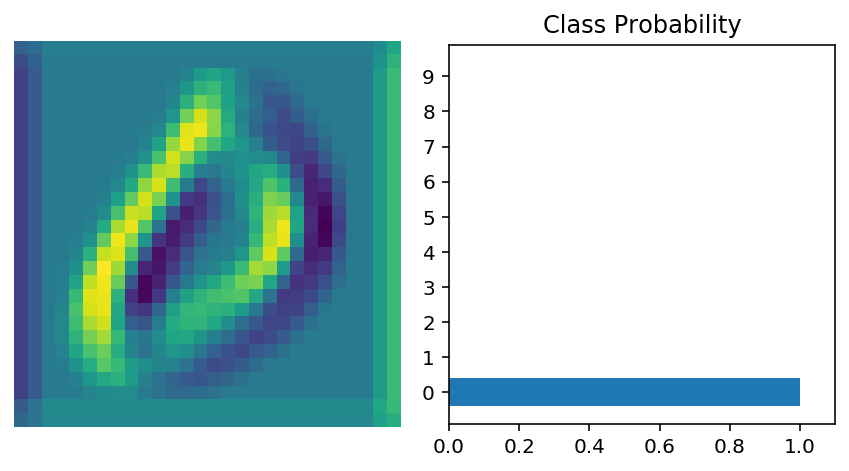

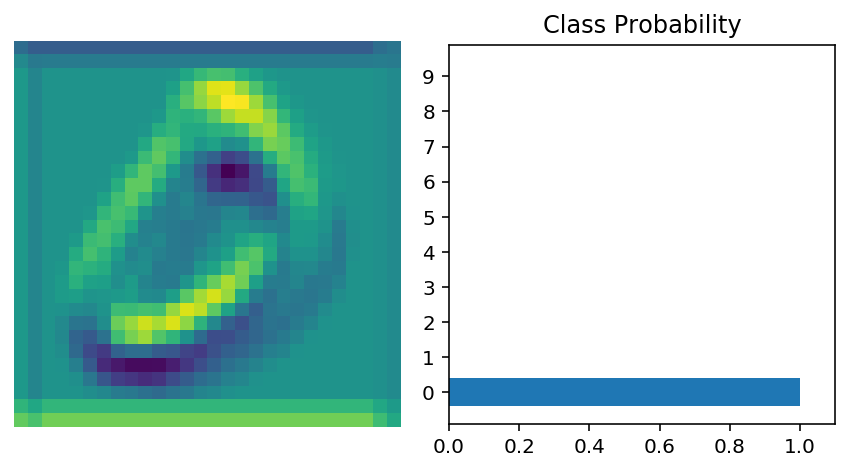

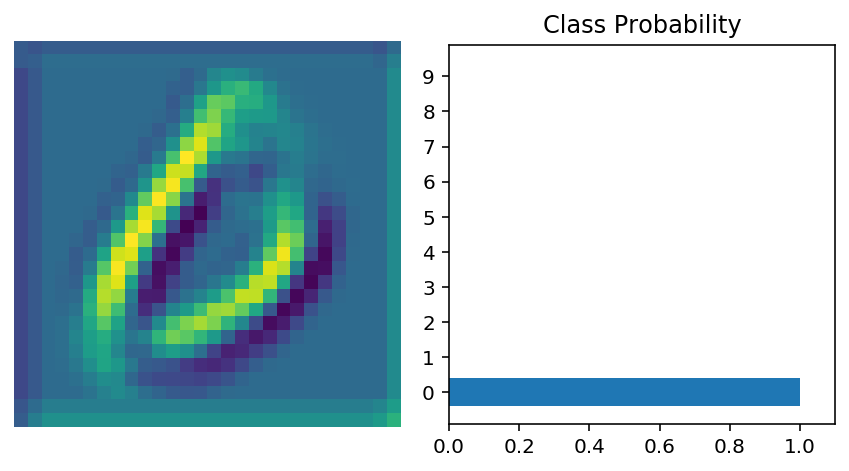

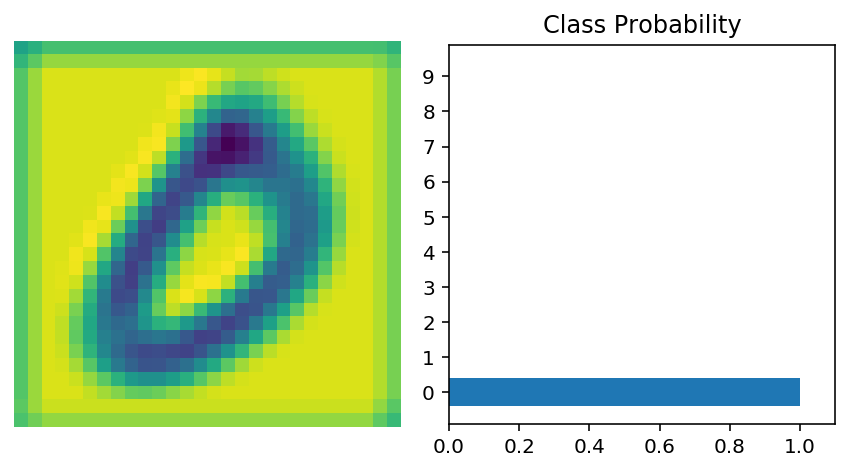

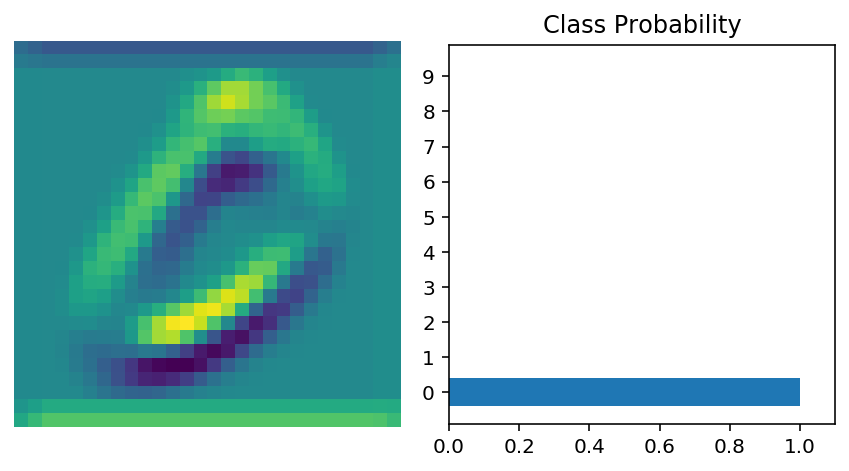

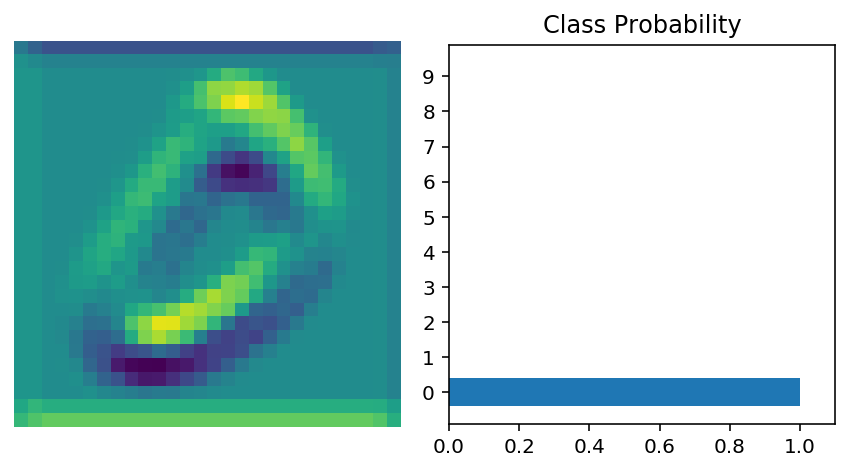

In [276]:
for i in range(6):
    helper.view_classify(feature[0][i].data.view(28, 28).cpu(), ps)

In [283]:
print(model)

Net(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (conv3): Conv2d(16, 120, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=120, out_features=84, bias=True)
  (fc2): Linear(in_features=84, out_features=10, bias=True)
)


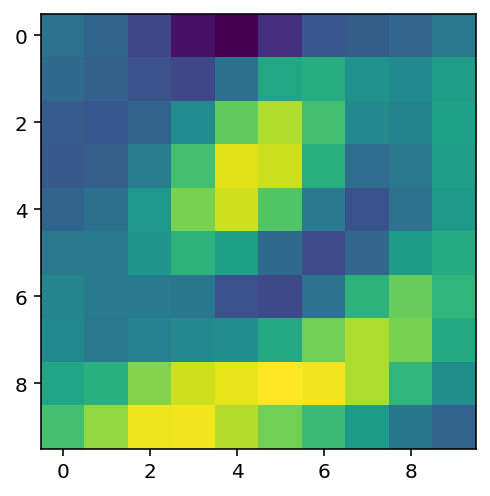

In [312]:
plt.imshow(feature[0][3].data.view(10, 10).cpu())

In [298]:
print(ps[0].cpu())

tensor([1.6227e+00, 8.6624e-05, 1.5793e+01, 6.4871e-01, 1.6703e-03, 2.3510e+01,
        5.9106e-03, 3.6925e-02, 2.3063e+05, 1.6237e-01])


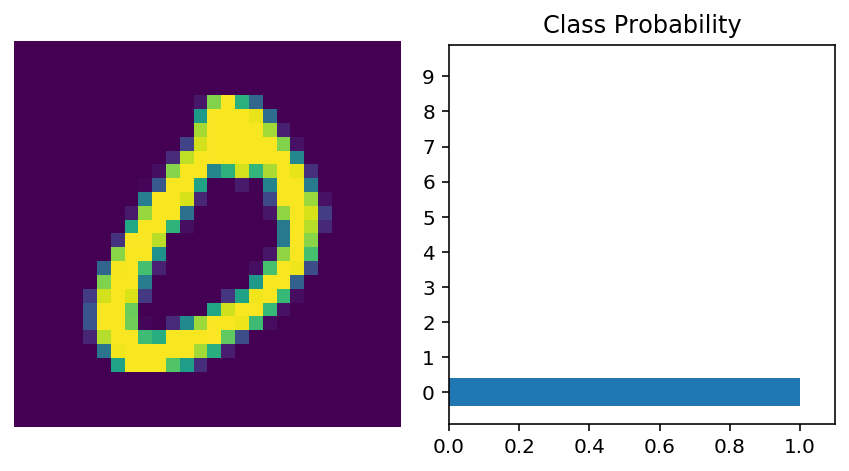

In [274]:
helper.view_classify(img.view(28, 28).cpu(), ps)

In [136]:
with torch.no_grad():
    model.eval()#这里就是关闭dropout了。
    for images, labels in testloader:
        images, labels = images.to(device), labels.to(device)
        log_ps = model(images)
        test_loss += criterion(log_ps, labels)
        
        ps = torch.exp(log_ps)
        top_p, top_class = ps.topk(1, dim=1)
        equals = top_class == labels.view(*top_class.shape)
        accuracy += torch.mean(equals.type(torch.FloatTensor))
        

torch.BoolTensor
tensor([[[-1., -1., -1.,  ..., -1., -1., -1.],
         [-1., -1., -1.,  ..., -1., -1., -1.],
         [-1., -1., -1.,  ..., -1., -1., -1.],
         ...,
         [-1., -1., -1.,  ..., -1., -1., -1.],
         [-1., -1., -1.,  ..., -1., -1., -1.],
         [-1., -1., -1.,  ..., -1., -1., -1.]],

        [[-1., -1., -1.,  ..., -1., -1., -1.],
         [-1., -1., -1.,  ..., -1., -1., -1.],
         [-1., -1., -1.,  ..., -1., -1., -1.],
         ...,
         [-1., -1., -1.,  ..., -1., -1., -1.],
         [-1., -1., -1.,  ..., -1., -1., -1.],
         [-1., -1., -1.,  ..., -1., -1., -1.]]])
torch.Size([2, 1, 28, 28])
torch.Size([2, 10])
tensor([[3.2010e-05, 4.5293e-05, 4.1860e-01, 4.6245e-01, 1.6518e-06, 1.1075e-04,
         3.4617e-10, 9.8728e-02, 1.9619e-03, 1.8070e-02],
        [2.1924e-07, 3.4873e-05, 4.5873e-05, 3.0053e-01, 4.9398e-08, 3.6226e-05,
         4.4946e-11, 6.3634e-01, 6.2980e-02, 3.6205e-05]])
label tensor(0, device='cuda:0')


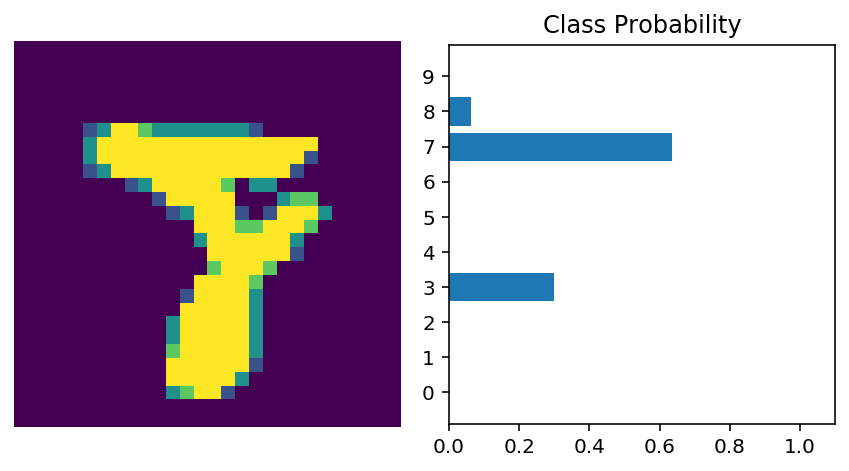

In [181]:
print(equals.type())
equals = equals.cpu()
#equals = equals.apply_(lambda x: not x)
images = images.cpu()
print(images[equals])

img1 = images[equals].unsqueeze(1)
img1 = img.to(device).clone()
model.eval()
# Turn off gradients to speed up this part
with torch.no_grad():
    print(img.shape)
    logps = model(img)

# Output of the network are log-probabilities, need to take exponential for probabilities
print(logps.shape)
ps = torch.softmax(logps, dim = 1).cpu()
print(ps)
print("label", labels[1])
helper.view_classify(img[1].view(1, 28, 28).cpu(), ps[1])

In [116]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import matplotlib.pyplot as plt

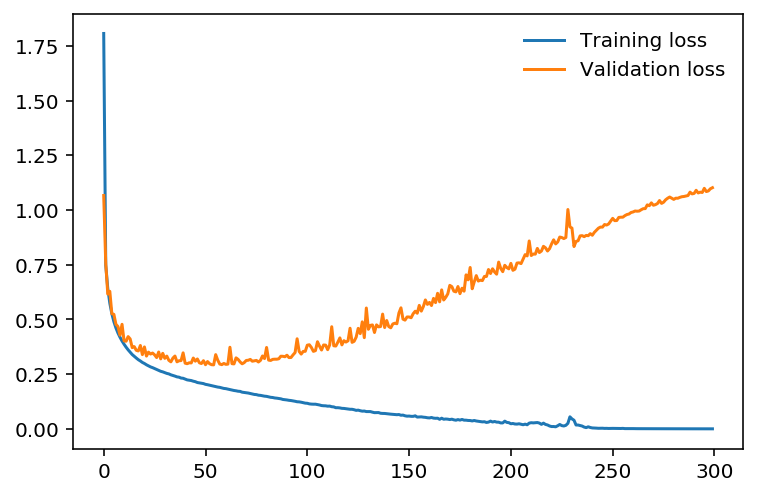

In [117]:
plt.plot(train_losses, label='Training loss')
plt.plot(test_losses, label='Validation loss')
plt.legend(frameon=False)

## Inference

Now that the model is trained, we can use it for inference. We've done this before, but now we need to remember to set the model in inference mode with `model.eval()`. You'll also want to turn off autograd with the `torch.no_grad()` context.

In [ ]:
# Import helper module (should be in the repo)
import helper

# Test out your network!

model.eval()

dataiter = iter(testloader)
images, labels = dataiter.next()
img = images[0]
# Convert 2D image to 1D vector
img = img.view(1, 784)

# Calculate the class probabilities (softmax) for img
with torch.no_grad():
    output = model.forward(img)

ps = torch.exp(output)

# Plot the image and probabilities
helper.view_classify(img.view(1, 28, 28), ps, version='Fashion')

## Next Up!

In the next part, I'll show you how to save your trained models. In general, you won't want to train a model everytime you need it. Instead, you'll train once, save it, then load the model when you want to train more or use if for inference.